In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
from PIL import Image
import os
import sys
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import imageio
from google.colab import files

Using TensorFlow backend.


In [0]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [0]:
from google.colab import files
uploaded = files.upload()

Saving content.jpeg to content (2).jpeg
Saving style.jpg to style (2).jpg


In [0]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
print(vgg.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
bloc

In [0]:
contlayers = ['block5_conv2']
stylelayers = ['block1_conv1',
               'block2_conv1',
               'block3_conv1',
               'block4_conv1',
               'block5_conv1'
              ]
nc = len(contlayers)
ns = len(stylelayers)

In [0]:
def vggmodel():
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    style_out = [vgg.get_layer(name).output for name in stylelayers]
    content_out = [vgg.get_layer(name).output for name in contlayers]
    total = content_out+style_out
    return models.Model(vgg.input, total)

In [0]:
def content_cost(a_c,a_g):
    n_h,n_w,n_c = a_c.get_shape().as_list()
    content_cost = tf.reduce_mean(tf.square(tf.subtract(a_c,a_g)))#/(4*n_h*n_w*n_c)
    content_cost = content_cost
    return content_cost

In [0]:
def contentl_cost(a_c,a_g):
    content_score = 0
    weight_per_content_layer = 1.0 / float(nc)
    for target_content, comb_content in zip(a_c, a_g):
        content_score += weight_per_content_layer* content_cost(target_content, comb_content[0])
    content_loss=content_score*1e3
    return content_loss

In [0]:
def gram_matrix(a):
    n = tf.shape(a)[0]
    gm = tf.matmul(a,tf.transpose(a))/tf.cast(n, tf.float32)
    return a

In [0]:
def style_cost(a_s,a_g):
    n_h,n_w,n_c = a_s.get_shape().as_list()
    a_s = np.reshape(a_s,[n_h*n_w,n_c])
    a_g = np.reshape(a_g,[n_h*n_w,n_c])
    gram_s = gram_matrix(tf.transpose(a_s))
    gram_g = gram_matrix(tf.transpose(a_g))
    style_cost = tf.reduce_sum(tf.square(tf.subtract(gram_s,gram_g)))#/(4*(n_c**2)*((n_h*n_w)**2))
    return style_cost

In [0]:
def style_cost_layers(so,go,coeff = 0.2):
    js = 0
    weight_per_style_layer = 1.0 / float(ns)
    for style,image in zip(so,go):
        j = style_cost(style,image[0])
        js+=j*weight_per_style_layer
    js*=1e-2
    return js

In [0]:
def total_cost(content_cost,style_cost,a = 1,b = 1):
    j =a* (content_cost)+b*(style_cost)
    return j

(200, 412, 3)
(1, 200, 412, 3)


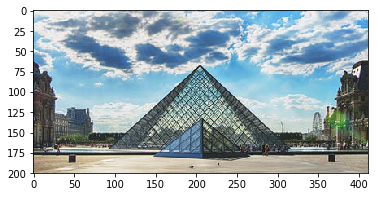

In [0]:
content = imageio.imread("content.jpeg")
imshow(content)
print(content.shape)
content = np.resize(content,(1,content.shape[0],content.shape[1],content.shape[2]))
print(content.shape)
content = tf.keras.applications.vgg19.preprocess_input(content)

(833, 1000, 3)
(1, 200, 412, 3)


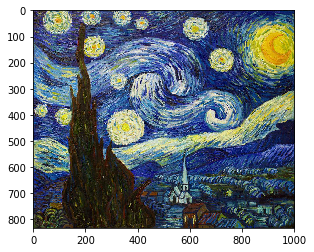

In [0]:
style = imageio.imread("style.jpg")
imshow(style)
print(style.shape)
style = np.resize(style,(200,412,3))
style = np.resize(style,(1,style.shape[0],style.shape[1],style.shape[2]))
print(style.shape)
style = tf.keras.applications.vgg19.preprocess_input(style)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 200, 412, 3)


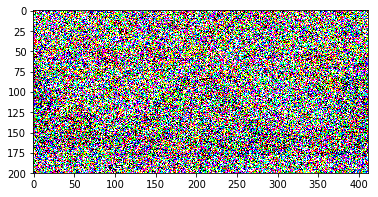

In [0]:
noise = np.random.uniform(-10,10,(1,200,412,3)).astype('float32')
generated = noise * 0.8 + content * (1 - noise)
imshow(generated[0])
generated = tf.keras.applications.vgg19.preprocess_input(generated)
print(generated.shape)

In [0]:
def loss(model,init_image,a_s,a_c):
    image = model(init_image)
    g_s = [img1 for img1 in image[:ns]]
    g_c = [img2 for img2 in image[ns:]]
    cl = contentl_cost(a_c,g_c)
    sl = style_cost_layers(a_s,g_s,coeff = 1)
    tl = total_cost(cl,sl,a = 1,b = 1)
    return tl,cl,sl

In [0]:
def grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = loss(**cfg)
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [0]:
import tensorflow.contrib.eager as tfe
import IPython.display
def final_transfer(content,style,generated,iterations = 1000):
    model = vggmodel()
    for layer in model.layers:
        layer.traianble = False
    con = model(content)
    sty = model(style)
    init_image = tfe.Variable(content, dtype=tf.float32)
    so = [style_out[0] for style_out in sty[:ns]]
    co = [cont_out[0] for cont_out in con[ns:]]
    opt = tf.train.AdamOptimizer(learning_rate= 5, beta1=0.9,beta2=0.999,epsilon=1e-19)
    cfg = {
      'model': model,
      'init_image': init_image,
      'a_s': so,
      'a_c': co
      }
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    num_rows = 2
    num_cols = 5
    imgs = []
    for i in range(iterations):
        grades, all_loss = grads(cfg)
        total, content, style = all_loss
        opt.apply_gradients([(grades,init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        if(i%100==0):
            image = init_image.numpy()
            x = image.copy()
            if len(x.shape) == 4:
              x = np.squeeze(x, 0)
            assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
            if len(x.shape) != 3:
              raise ValueError("Invalid input to deprocessing image")
            x[:, :, 0] += 103.939
            x[:, :, 1] += 116.779
            x[:, :, 2] += 123.68
            x = x[:, :, ::-1]
            x = np.clip(x, 0, 255).astype('uint8')
            imgs.append(x)
            IPython.display.display_png(Image.fromarray(x))
            print('Iteration: {}'.format(i))
            print('Total loss: {:.4e}'.format(total))
            print('style loss: {:.4e}'.format(style))
            print('content loss: {:.4e}'.format(content))
        for i,img in enumerate(imgs):
          plt.subplot(num_rows,num_cols,i+1)
          plt.imshow(img)
          plt.xticks([])
          plt.yticks([])
        

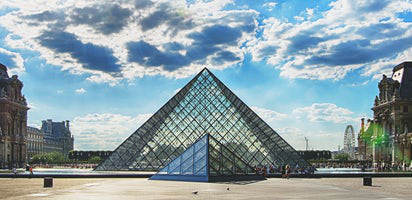

Iteration: 0
Total loss: 3.0447e+09
style loss: 3.0447e+09
content loss: 0.0000e+00


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


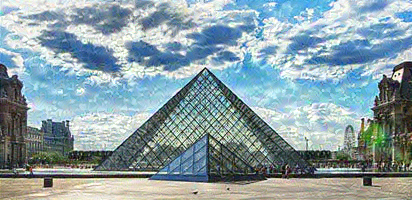

Iteration: 100
Total loss: 3.0789e+09
style loss: 3.0789e+09
content loss: 2.3775e+04


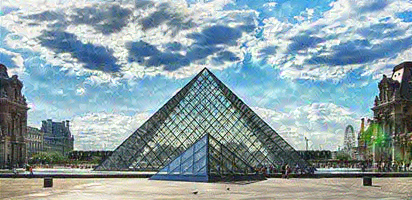

Iteration: 200
Total loss: 3.0735e+09
style loss: 3.0734e+09
content loss: 1.7791e+04


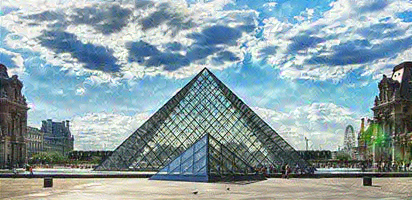

Iteration: 300
Total loss: 3.0706e+09
style loss: 3.0706e+09
content loss: 7.2973e+03


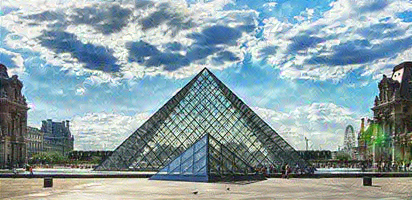

Iteration: 400
Total loss: 3.0671e+09
style loss: 3.0671e+09
content loss: 1.1549e+04


KeyboardInterrupt: ignored

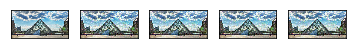

In [0]:
final_transfer(content,style,generated,iterations = 1000)